必要的庫安裝（僅首次運行時執行）

In [38]:
#conda install pandas matplotlib seaborn scikit-learn imbalanced-learn pyyaml shap xgboost joblib

# 專案：預測病人生死（has_died）

## 1. 初始化和配置加載

In [39]:
import pandas as pd
import numpy as np
import yaml
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import missingno as msno
import featuretools as ft
import joblib
import time
import random
import os
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    average_precision_score,
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline

import xgboost as xgb
from xgboost import XGBClassifier

# 設置 Matplotlib 風格
sns.set(style="whitegrid")


## 2. 全域設定與隨機種子

In [40]:
# 全域隨機種子設定，確保實驗可重現
SEED = 7
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# 設定 XGBoost 的全域隨機種子
xgb.set_config(verbosity=0)

## 3. 設置 Logging

In [41]:
# 建立 logs 資料夾（若不存在）
os.makedirs("logs", exist_ok=True)

# 設定 logging 配置
logging.basicConfig(
    filename='logs/training_log.log',  # Log 檔案名稱
    filemode='a',                      # 'a' 表示追加模式，'w' 表示覆蓋模式
    format='%(asctime)s - %(levelname)s - %(message)s',
    level=logging.INFO                  # 設定日誌等級
)

logging.info("Logging initialized. Starting the training process.")

## 4. 載入配置檔案

In [42]:
# 載入配置檔案
try:
    with open("config/config.yaml", "r", encoding="utf-8") as f:
        config = yaml.safe_load(f)
    logging.info("Configuration loaded successfully.")
except Exception as e:
    logging.error(f"Error loading configuration: {e}")
    raise

## 5. 定義輔助函數

In [43]:
def load_data(file_path):
    """從 CSV 檔案載入資料"""
    try:
        data = pd.read_csv(file_path)
        logging.info(f"Data loaded successfully from {file_path}. Shape: {data.shape}")
        return data
    except Exception as e:
        logging.error(f"Error loading data from {file_path}: {e}")
        raise

def save_data(df, file_path):
    """將資料儲存為 CSV 檔案"""
    try:
        df.to_csv(file_path, index=False)
        logging.info(f"Data saved to {file_path}")
    except Exception as e:
        logging.error(f"Error saving data to {file_path}: {e}")
        raise

def set_random_seed(seed=42):
    """統一設定隨機種子"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

## 6. 資料載入與初步檢查

In [44]:
def data_loading_and_inspection(config):
    """載入資料並進行初步檢查"""
    # 載入資料
    train_X_path = config['data_paths']['train_X']
    train_y_path = config['data_paths']['train_y']
    test_X_path = config['data_paths']['test_X']

    train_data = load_data(train_X_path)
    train_target = load_data(train_y_path)
    test_data = load_data(test_X_path)

    # 保留 patient_id
    train_patient_ids = train_data['patient_id']
    test_patient_ids = test_data['patient_id']

    # 打印基本資訊
    logging.info(f"Training data shape: {train_data.shape}")
    logging.info(f"Test data shape: {test_data.shape}")
    logging.info(f"Target shape: {train_target.shape}")

    print("Training data shape:", train_data.shape)
    print("Test data shape:", test_data.shape)
    print("Target shape:", train_target.shape)

    return train_data, train_target, test_data, train_patient_ids, test_patient_ids

# 載入資料
train_data, train_target, test_data, train_patient_ids, test_patient_ids = data_loading_and_inspection(config)

Training data shape: (44939, 83)
Test data shape: (19260, 83)
Target shape: (44939, 1)


## 6.1 資料分析(缺失值,資料不平衡...)

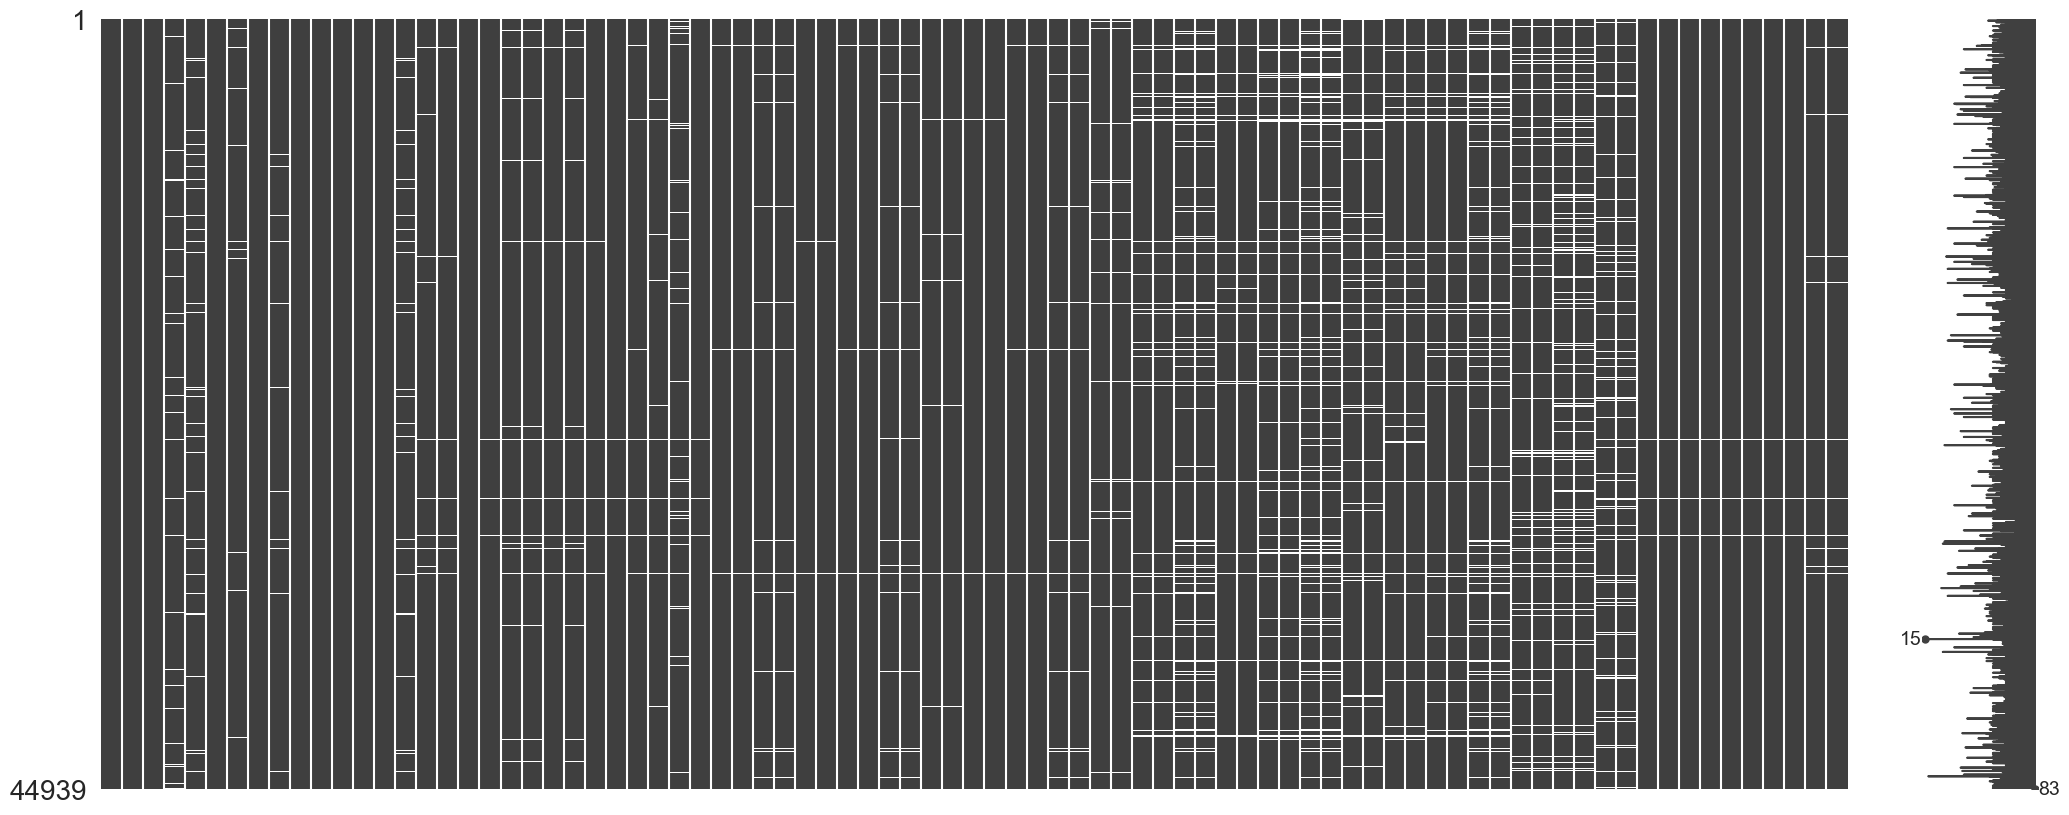

                          Missing Values  Percentage (%)
d1_potassium_min                  4748.0       10.565433
d1_potassium_max                  4748.0       10.565433
h1_mbp_noninvasive_min            4495.0       10.002448
h1_mbp_noninvasive_max            4495.0       10.002448
apache_4a_icu_death_prob          3891.0        8.658404
...                                  ...             ...
d1_heartrate_max                    65.0        0.144641
d1_heartrate_min                    65.0        0.144641
icu_admit_source                    51.0        0.113487
gender                              13.0        0.028928
Total                            96200.0        5.158264

[75 rows x 2 columns]


In [45]:
#顯示缺失值
msno.matrix(train_data)
plt.show()

def missing_values_table(df):
    """
    生成缺失值的表格，包括缺失值數量和比例
    """
    # 計算每列的缺失值數量和比例
    missing_values = df.isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100

    # 創建數據框顯示結果
    missing_table = pd.DataFrame({
        'Missing Values': missing_values,
        'Percentage (%)': missing_percentage
    })

    # 排序按缺失值數量降序
    missing_table = missing_table[missing_table['Missing Values'] > 0].sort_values(
        by='Missing Values', ascending=False
    )

    # 添加總計行
    missing_table.loc['Total'] = missing_table.sum(numeric_only=True)
    missing_table.loc['Total', 'Percentage (%)'] = (missing_table['Missing Values'].sum() / (len(df) * len(df.columns))) * 100

    return missing_table

# 呼叫函數並印出缺失值表格
missing_table = missing_values_table(train_data)
print(missing_table)


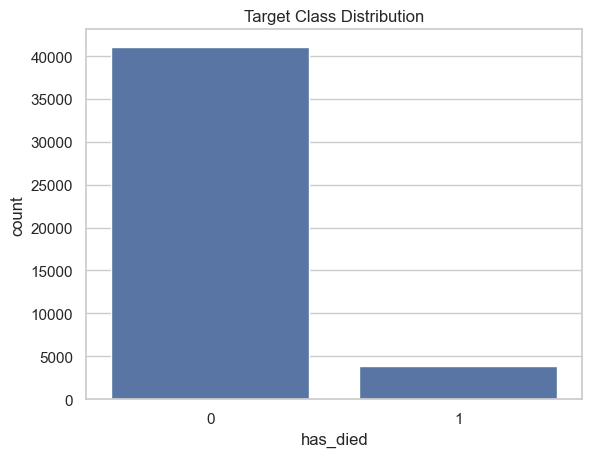

In [46]:
#資料不平衡
sns.countplot(x='has_died', data=train_target)
plt.title('Target Class Distribution')
plt.show()


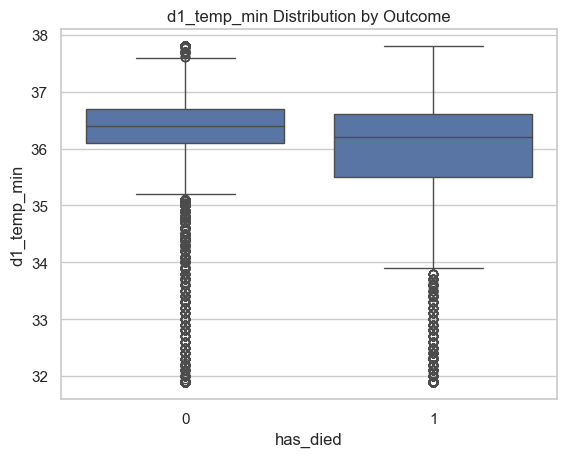

In [47]:
#異常值檢查
sns.boxplot(x='has_died', y='d1_temp_min', data=pd.concat([train_data, train_target], axis=1))
plt.title('d1_temp_min Distribution by Outcome')
plt.show()

## 7. 資料預處理與特徵工程

In [48]:
def data_preprocessing(train_data, test_data):
    """數據預處理與特徵工程"""

    # 刪除不需要的列
    columns_to_drop = ['encounter_id', 'patient_id']
    train_data = train_data.drop(columns=columns_to_drop, errors='ignore')
    test_data = test_data.drop(columns=columns_to_drop, errors='ignore')

    logging.info(f"Columns dropped: {columns_to_drop}")

    # 處理異常值
    train_data, test_data = handle_outliers(train_data, test_data)

    # 合併稀有類別
    train_data, test_data = merge_rare_categories(train_data, test_data)

    # 衍生特徵創建
    train_data, test_data = feature_engineering(train_data, test_data)

    # 處理缺失值
    train_data, test_data = handle_missing_values(train_data, test_data)

    # 更新數值型和類別型特徵列表
    numerical_columns = train_data.select_dtypes(include=[np.number]).columns.tolist()
    categorical_columns = train_data.select_dtypes(exclude=[np.number]).columns.tolist()

    logging.info(f"Numerical columns: {numerical_columns}")
    logging.info(f"Categorical columns: {categorical_columns}")

    return train_data, test_data, numerical_columns, categorical_columns

def handle_outliers(train_data, test_data):
    """處理異常值"""
    # 定義需要處理的列（數值型）
    numerical_columns = train_data.select_dtypes(include=[np.number]).columns.tolist()

    # 處理負值（如 pre_icu_los_days）
    for col in ['pre_icu_los_days']:
        train_data[col] = train_data[col].apply(lambda x: max(x, 0))
        test_data[col] = test_data[col].apply(lambda x: max(x, 0))

    # 處理標記為 -1 的值（如 apache_4a_hospital_death_prob）
    for col in ['apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob']:
        train_data[col] = train_data[col].replace(-1, np.nan)
        test_data[col] = test_data[col].replace(-1, np.nan)

    # 對數值型特徵進行處理
    for col in numerical_columns:
        # 根據特徵的分佈，決定是否進行對數變換
        if (train_data[col] > 0).all():
            train_data[col] = np.log1p(train_data[col])
            test_data[col] = np.log1p(test_data[col])

    logging.info("Outliers handled using domain-specific adjustments and transformations.")

    return train_data, test_data

def merge_rare_categories(train_data, test_data, threshold=1):
    """合併稀有類別"""
    categorical_columns = train_data.select_dtypes(exclude=[np.number]).columns.tolist()

    for col in categorical_columns:
        freq = train_data[col].value_counts(normalize=True) * 100
        rare_labels = freq[freq < threshold].index
        train_data[col] = train_data[col].replace(rare_labels, '其他')
        test_data[col] = test_data[col].replace(rare_labels, '其他')

    logging.info("Rare categories merged into '其他'.")

    return train_data, test_data

def feature_engineering(train_data, test_data):
    """衍生特徵創建"""

    # 將 apache_4a_hospital_death_prob 分段
    risk_bins = [0, 0.3, 0.7, 1.0]
    risk_labels = ['低風險', '中風險', '高風險']

    for dataset in [train_data, test_data]:
        dataset['apache_4a_hospital_death_prob_risk'] = pd.cut(
            dataset['apache_4a_hospital_death_prob'],
            bins=risk_bins,
            labels=risk_labels,
            include_lowest=True
        )

    # 創建綜合風險指標
    weight_hospital = 0.8
    weight_icu = 0.2

    for dataset in [train_data, test_data]:
        dataset['composite_risk'] = (
            dataset['apache_4a_hospital_death_prob'] * weight_hospital +
            dataset['apache_4a_icu_death_prob'] * weight_icu
        )

    # 創建更多的交互特徵
    for dataset in [train_data, test_data]:
        if 'age' in dataset.columns and 'composite_risk' in dataset.columns:
            dataset['age*composite_risk'] = dataset['age'] * dataset['composite_risk']
        if 'bmi' in dataset.columns and 'composite_risk' in dataset.columns:
            dataset['bmi*composite_risk'] = dataset['bmi'] * dataset['composite_risk']

    logging.info("Feature engineering completed with additional interaction features.")

    return train_data, test_data

def handle_missing_values(train_data, test_data):
    """處理缺失值"""

    # 計算每個字段的缺失比例
    missing_ratio = train_data.isnull().mean() * 100

    # 定義需要刪除的列（缺失比例 > 30%）
    columns_to_drop_missing = missing_ratio[missing_ratio > 30].index.tolist()

    # 刪除高缺失比例的列
    train_data = train_data.drop(columns=columns_to_drop_missing)
    test_data = test_data.drop(columns=columns_to_drop_missing)

    logging.info(f"Columns dropped due to high missing ratio (>30%): {columns_to_drop_missing}")

    # 創建缺失標記（缺失率 > 5%）
    for col in train_data.columns:
        if train_data[col].isnull().mean() * 100 > 5:
            train_data[f'{col}_missing'] = train_data[col].isnull().astype(int)
            test_data[f'{col}_missing'] = test_data[col].isnull().astype(int)

    logging.info("Missing flags created for features with >5% missing values.")

    return train_data, test_data

# 進行數據預處理與特徵工程
train_data, test_data, numerical_columns, categorical_columns = data_preprocessing(train_data, test_data)

## 8. 資料分割

In [49]:
def split_data(train_data, train_target):
    """分割資料集並返回訓練集與驗證集"""
    X = train_data
    y = train_target['has_died']

    # 分割訓練集和驗證集
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=SEED, stratify=y
    )

    logging.info(f"Data split into training and validation sets. Training shape: {X_train.shape}, Validation shape: {X_val.shape}")

    return X_train, X_val, y_train, y_val

X_train, X_val, y_train, y_val = split_data(train_data, train_target)

## 9. 定義預處理器

In [50]:
def define_preprocessor(numerical_columns, categorical_columns):
    """定義預處理器"""

    # 數值型特徵使用多重插補
    numerical_imputer = IterativeImputer(random_state=SEED)

    # 類別型特徵使用眾數填補
    categorical_imputer = SimpleImputer(strategy='most_frequent')

    # 定義 ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('imputer', numerical_imputer),
                ('scaler', StandardScaler()),
            ]), numerical_columns),
            ('cat', Pipeline([
                ('imputer', categorical_imputer),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), categorical_columns)
        ],
        remainder='drop'
    )

    logging.info("Preprocessor defined.")

    return preprocessor

preprocessor = define_preprocessor(numerical_columns, categorical_columns)

## 10. 定義模型與流水線

In [51]:
def define_models(preprocessor, y_train):
    """定義 XGBoost 模型與流水線"""

    # 計算類別權重
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

    # 計算 scale_pos_weight
    scale_pos_weight = class_weights_dict[1] / class_weights_dict[0]
    logging.info(f"Calculated scale_pos_weight: {scale_pos_weight}")

    # 定義包含預處理器、ADASYN 和 XGBoost 模型的流水線
    pipelines = {}

    # XGBoost
    pipelines['XGBoost'] = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('adasyn', ADASYN(sampling_strategy='minority', random_state=SEED, n_jobs=-1)),
        ('classifier', XGBClassifier(
            eval_metric='logloss',
            random_state=SEED,
            verbosity=0,
            scale_pos_weight=scale_pos_weight,
            n_jobs=-1,
            tree_method='gpu_hist',  # 使用 GPU
        ))
    ])

    logging.info("XGBoost pipeline defined.")

    return pipelines

pipelines = define_models(preprocessor, y_train)


## 11. 超參數調整

In [ ]:
import optuna
from optuna.samplers import TPESampler
def hyperparameter_tuning(pipelines, X_train, y_train):
    """超參數調整"""
    best_models = {}
    evaluation_scores = {}

    for name, pipeline in pipelines.items():
        logging.info(f"Starting hyperparameter tuning for {name}")

        def objective(trial):
            if name == 'XGBoost':
                params =  params = {
                'classifier__n_estimators': trial.suggest_int('classifier__n_estimators', 450, 500),
                'classifier__max_depth': trial.suggest_int('classifier__max_depth', 8, 12),
                'classifier__learning_rate': trial.suggest_float('classifier__learning_rate', 0.01, 0.038, log=True),
                'classifier__subsample': trial.suggest_float('classifier__subsample', 0.8, 0.9),
                'classifier__colsample_bytree': trial.suggest_float('classifier__colsample_bytree', 0.7, 0.75),
                }
            else:
                params = {}

            pipeline.set_params(**params)

            scores = cross_val_score(pipeline, X_train, y_train, cv=2, scoring='f1_macro', n_jobs=-1)
            return scores.mean()

        study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=SEED))
        study.optimize(objective, n_trials=1)

        logging.info(f"Best parameters for {name}: {study.best_params}")
        logging.info(f"Best F1 score for {name}: {study.best_value}")

        # 設定最佳參數
        best_params = study.best_params
        pipeline.set_params(**best_params)

        # 訓練最佳模型
        pipeline.fit(X_train, y_train)

        best_models[name] = pipeline
        evaluation_scores[name] = study.best_value

    return best_models

best_models = hyperparameter_tuning(pipelines, X_train, y_train)


[I 2024-11-25 16:40:16,528] A new study created in memory with name: no-name-0bb982c6-d39d-49eb-bed8-ba9c45ba0324
C:\Users\richardlin\AppData\Local\Temp\ipykernel_24728\1764678826.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'classifier__learning_rate': trial.suggest_loguniform('classifier__learning_rate', 0.01, 0.1),
C:\Users\richardlin\AppData\Local\Temp\ipykernel_24728\1764678826.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'classifier__subsample': trial.suggest_uniform('classifier__subsample', 0.6, 0.9),
C:\Users\richardlin\AppData\Local\Temp\ipykernel_24728\1764678826.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in

## 10.1 資料視覺化

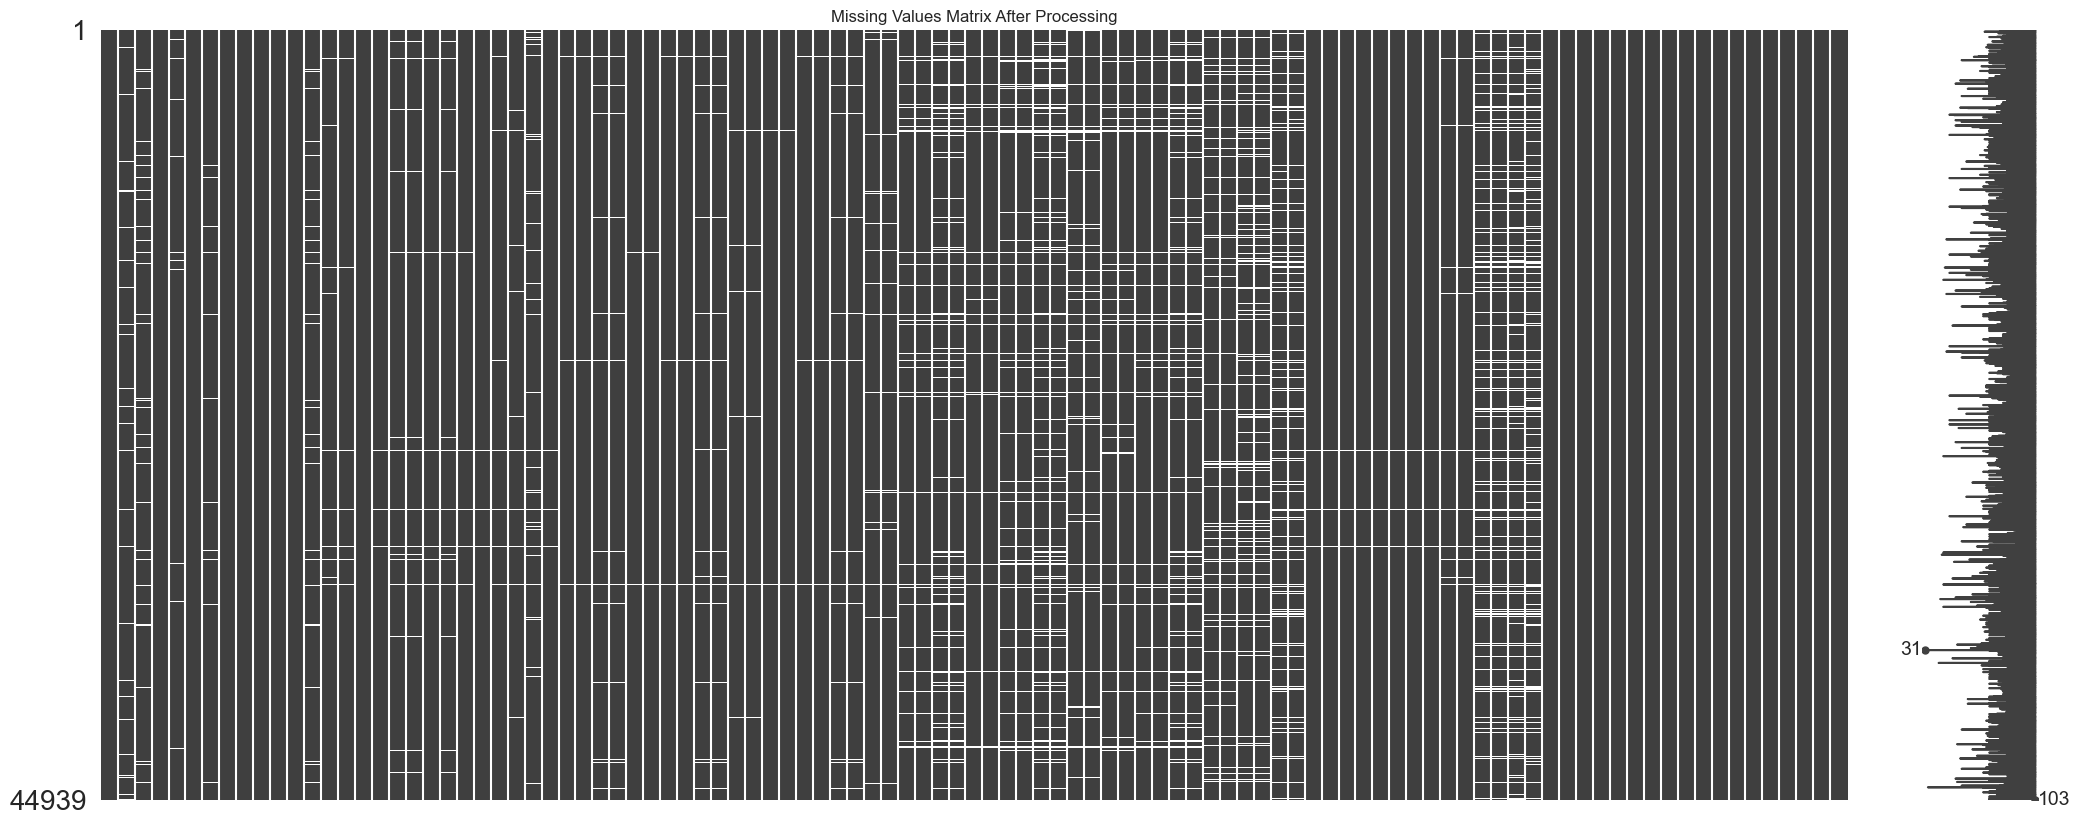

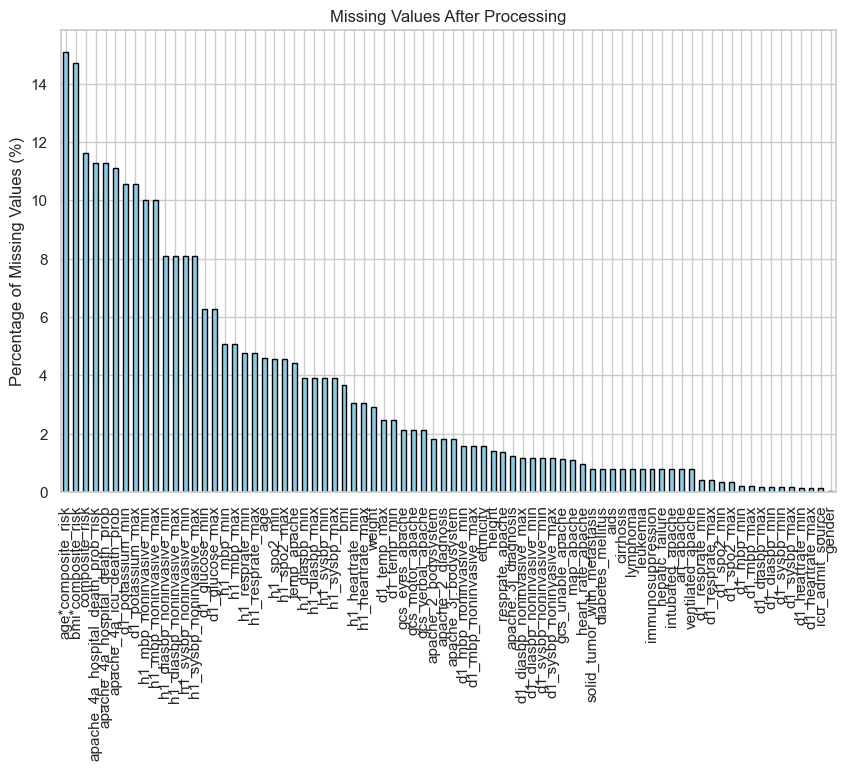

In [53]:
# 使用 missingno 繪製矩陣圖
import missingno as msno
msno.matrix(train_data)
plt.title("Missing Values Matrix After Processing")
plt.show()

# 繪製缺失值百分比條形圖
missing_ratio_after = train_data.isnull().mean() * 100
missing_ratio_after = missing_ratio_after[missing_ratio_after > 0]  # 只顯示有缺失的特徵
missing_ratio_after.sort_values(ascending=False).plot(
    kind='bar', figsize=(10, 6), color='skyblue', edgecolor='black'
)
plt.ylabel("Percentage of Missing Values (%)")
plt.title("Missing Values After Processing")
plt.show()

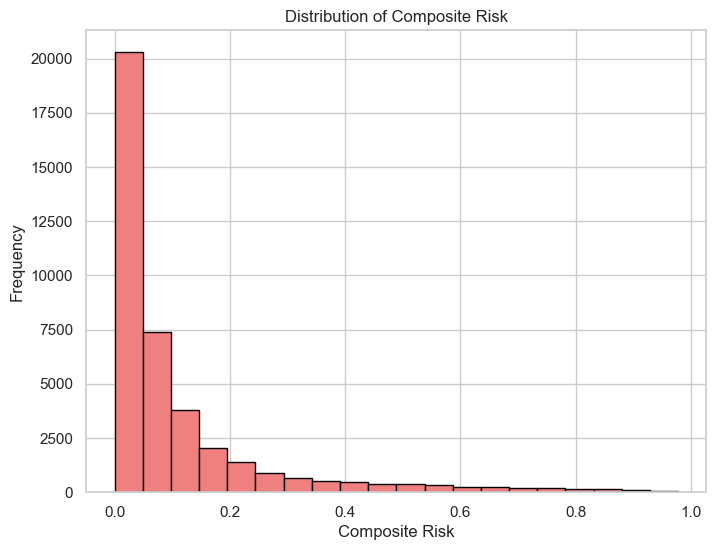

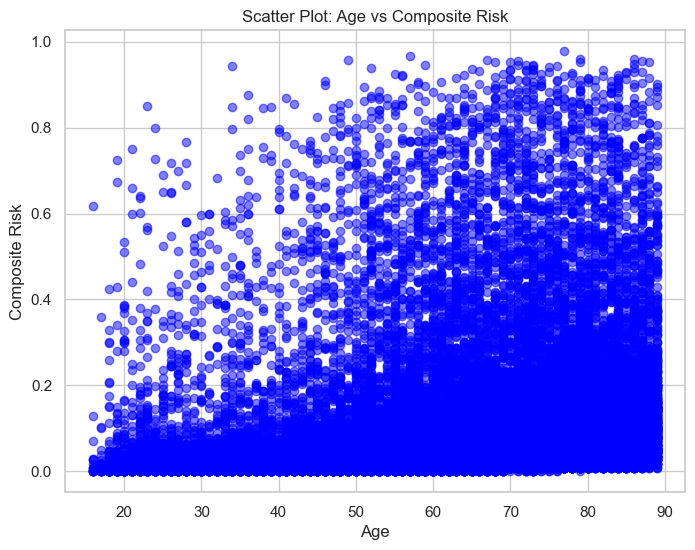

In [54]:
# 繪製 composite_risk 和 age*composite_risk 的分佈
train_data['composite_risk'].hist(bins=20, color='lightcoral', edgecolor='black', figsize=(8, 6))
plt.xlabel('Composite Risk')
plt.ylabel('Frequency')
plt.title("Distribution of Composite Risk")
plt.show()

# 散點圖檢查 age 與 composite_risk 的交互特徵
plt.figure(figsize=(8, 6))
plt.scatter(train_data['age'], train_data['composite_risk'], alpha=0.5, c='blue')
plt.xlabel('Age')
plt.ylabel('Composite Risk')
plt.title("Scatter Plot: Age vs Composite Risk")
plt.show()

## 12. 模型評估與選擇

In [56]:
def evaluate_model(model, X_val, y_val, model_name):
    """在驗證集上進行評估"""
    try:
        # 預測
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:,1]

        # 評估指標
        f1 = f1_score(y_val, y_pred, average='macro')
        auc = roc_auc_score(y_val, y_proba)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        pr_auc = average_precision_score(y_val, y_proba)

        print(f"{model_name} - Validation F1 Score: {f1}")
        print(f"{model_name} - Validation AUROC: {auc}")
        print(f"{model_name} - Validation Precision: {precision}")
        print(f"{model_name} - Validation Recall: {recall}")
        print(f"{model_name} - Validation PR AUC: {pr_auc}")
        print("\nClassification Report:\n", classification_report(y_val, y_pred))
        print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred))

        # 記錄評估結果
        logging.info(f"{model_name} - Validation F1 Score: {f1}")
        logging.info(f"{model_name} - Validation AUROC: {auc}")
        logging.info(f"{model_name} - Validation Precision: {precision}")
        logging.info(f"{model_name} - Validation Recall: {recall}")
        logging.info(f"{model_name} - Validation PR AUC: {pr_auc}")
        logging.info(f"{model_name} - Classification Report:\n{classification_report(y_val, y_pred)}")
        logging.info(f"{model_name} - Confusion Matrix:\n{confusion_matrix(y_val, y_pred)}")

    except Exception as e:
        logging.error(f"Error during model evaluation for {model_name}: {e}")
        print(f"Error during model evaluation for {model_name}: {e}")

# 只評估 XGBoost 模型
best_model = best_models['XGBoost']
evaluate_model(best_model, X_val, y_val, 'XGBoost')

XGBoost - Validation F1 Score: 0.5338236285517279
XGBoost - Validation AUROC: 0.8752215766718054
XGBoost - Validation Precision: 0.18508930882733626
XGBoost - Validation Recall: 0.9213917525773195
XGBoost - Validation PR AUC: 0.43845103442260336

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.62      0.76      8212
           1       0.19      0.92      0.31       776

    accuracy                           0.64      8988
   macro avg       0.59      0.77      0.53      8988
weighted avg       0.92      0.64      0.72      8988


Confusion Matrix:
 [[5064 3148]
 [  61  715]]


## 13. 特徵重要性分析（SHAP）

c:\Users\richardlin\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\plots\_beeswarm.py:950: UserWarning: Glyph 20302 (\N{CJK UNIFIED IDEOGRAPH-4F4E}) missing from font(s) Arial.
  pl.tight_layout()
c:\Users\richardlin\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\plots\_beeswarm.py:950: UserWarning: Glyph 39080 (\N{CJK UNIFIED IDEOGRAPH-98A8}) missing from font(s) Arial.
  pl.tight_layout()
c:\Users\richardlin\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\plots\_beeswarm.py:950: UserWarning: Glyph 38570 (\N{CJK UNIFIED IDEOGRAPH-96AA}) missing from font(s) Arial.
  pl.tight_layout()
C:\Users\richardlin\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20302 (\N{CJK UNIFIED IDEOGRAPH-4F4E}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\richardlin\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39080 (\N{CJK UN

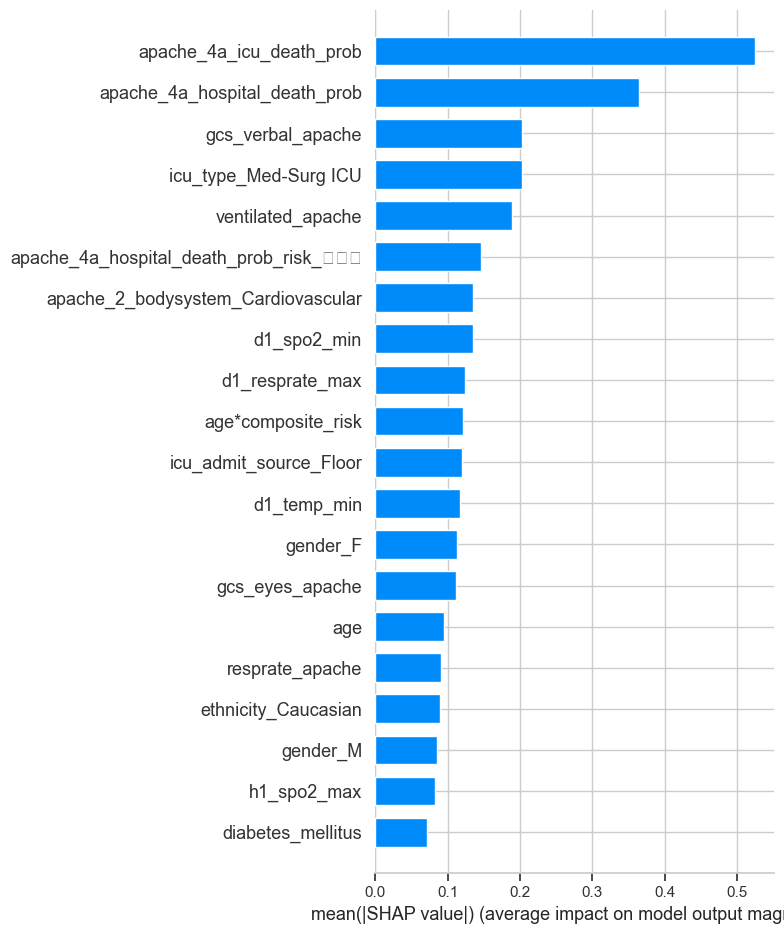

In [57]:
def shap_analysis(model, X_train):
    """使用 SHAP 進行特徵重要性分析"""
    try:
        # 預處理後的訓練資料
        preprocessed_X_train = model.named_steps['preprocessor'].transform(X_train)

        # 獲取特徵名稱
        categorical_columns = model.named_steps['preprocessor'].transformers_[1][2]
        onehot_encoder = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
        onehot_feature_names = onehot_encoder.get_feature_names_out(categorical_columns)
        numerical_columns = model.named_steps['preprocessor'].transformers_[0][2]
        feature_names = np.concatenate([numerical_columns, onehot_feature_names])

        # 使用 SHAP
        classifier = model.named_steps['classifier']
        if isinstance(classifier, XGBClassifier):
            explainer = shap.TreeExplainer(classifier)
            shap_values = explainer.shap_values(preprocessed_X_train)
        else:
            logging.warning("SHAP analysis not supported for this classifier.")
            return

        # 繪製 SHAP summary plot
        shap.summary_plot(shap_values, features=preprocessed_X_train, feature_names=feature_names, plot_type="bar", max_display=20)

        logging.info("SHAP feature importance plot generated.")
    except Exception as e:
        logging.error(f"Error during SHAP analysis: {e}")
        print(f"Error during SHAP analysis: {e}")

# SHAP 分析
shap_analysis(best_model, X_train)

## 14. 保存最佳模型

In [58]:
def save_model(model, file_path='trained_best_model.pkl'):
    """保存最佳模型"""
    try:
        joblib.dump(model, file_path)
        logging.info(f"Best model saved successfully as '{file_path}'.")
        print(f"Best model saved as '{file_path}'.")
    except Exception as e:
        logging.error(f"Error saving the model: {e}")
        print(f"Error saving the model: {e}")

# 保存模型
save_model(best_model)

Best model saved as 'trained_best_model.pkl'.


## 15. 在測試集上進行預測並生成提交文件

In [59]:
def create_submission_file(model, test_data, patient_ids, file_path='submission.csv'):
    """生成提交文件"""
    try:
        predictions = model.predict(test_data)
        submission = pd.DataFrame({
            'patient_id': patient_ids,
            'has_died': predictions
        })
        submission.to_csv(file_path, index=False)
        logging.info(f"Submission file saved successfully as '{file_path}'.")
        print(f"Submission file saved to {file_path}")
    except Exception as e:
        logging.error(f"Error creating submission file: {e}")
        print(f"Error creating submission file: {e}")

# 在測試集上進行預測
create_submission_file(best_model, test_data, test_patient_ids)

Submission file saved to submission.csv


## 16. 模型監控

In [60]:
def monitor_model(model, X_val, y_val):
    """監控模型性能"""
    import time

    # 計算預測時間
    start_time = time.time()
    predictions = model.predict(X_val)
    end_time = time.time()

    # 計算評估指標
    accuracy = accuracy_score(y_val, predictions)
    f1 = f1_score(y_val, predictions, average='macro')
    latency = end_time - start_time

    # 顯示結果
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"Prediction Latency: {latency:.2f} seconds")

    # 記錄到日誌文件
    logging.info(f"Monitoring results - Accuracy: {accuracy}, F1 Score: {f1}, Latency: {latency:.2f} seconds")

    # 返回結果
    return accuracy, f1, latency

# 模型監控
accuracy, f1, latency = monitor_model(best_model, X_val, y_val)

print(f"Final Monitoring Results -> Accuracy: {accuracy}, F1: {f1}, Latency: {latency:.2f} seconds")

Accuracy: 0.6429684023141967
F1 Score: 0.5338236285517279
Prediction Latency: 1.50 seconds
Final Monitoring Results -> Accuracy: 0.6429684023141967, F1: 0.5338236285517279, Latency: 1.50 seconds


## 17. 模型部署

In [61]:
def model_deployment(model, deployment_path='model_api.py'):
    """模型部署 - 使用 Flask 建構 API"""
    try:
        api_code = f"""
from flask import Flask, request, jsonify
import joblib
import pandas as pd

app = Flask(__name__)

# 加載模型
model = joblib.load('trained_best_model.pkl')

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json(force=True)
    input_df = pd.DataFrame([data])
    prediction = model.predict(input_df)
    return jsonify({{'prediction': int(prediction[0])}})

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000)
"""
        with open(deployment_path, 'w') as f:
            f.write(api_code)
        
        logging.info(f"Model API script saved successfully as '{deployment_path}'.")
        print(f"Model API script saved as '{deployment_path}'.")
    except Exception as e:
        logging.error(f"Error during model deployment: {e}")
        print(f"Error during model deployment: {e}")

# 模型部署
model_deployment('model_api.py')

Model API script saved as 'model_api.py'.


## 18. 結束

In [62]:
logging.info("Training and evaluation process completed.")
print("所有步驟已完成。請檢查 'logs/training_log.log' 以獲取詳細日誌。")

所有步驟已完成。請檢查 'logs/training_log.log' 以獲取詳細日誌。
